# Classification of genetic mutations based on clinical evidence provided as text description. <a class='tocSkip'>

**NOTICE: This is unfinished, active working copy**

Main approach will be first using NLP techniques to transform text description into features needed later for a few classifiers. Then choosing best working one.

In [139]:
import numpy as np
import pandas as pd

import gensim
import nltk

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.preprocessing import LabelEncoder

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import StratifiedKFold

from sklearn.decomposition import TruncatedSVD
from sklearn.svm import SVC

from sklearn.metrics import accuracy_score, log_loss
from scikitplot.metrics import plot_confusion_matrix

### Loading data

In [93]:
train_text = pd.read_csv('data/training_text', sep='\|\|', header=None, skiprows=1, names=['ID','Text'], engine='python')
train_text.head(2)

,ID,Text
0,0,Cyclin-dependent kinases (CDKs) regulate a var...
1,1,Abstract Background Non-small cell lung canc...


In [94]:
train_variants = pd.read_csv('data/training_variants')
train_variants.head(2)

,ID,Gene,Variation,Class
0,0,FAM58A,Truncating Mutations,1
1,1,CBL,W802*,2


In [95]:
test_text = pd.read_csv('data/test_text', sep='\|\|', header=None, names=['ID','Text'], engine='python')
test_text.head(2)

,ID,Text
0,0,Oncogenic mutations in the monomeric Casitas B...
1,1,Abstract Background Non-small cell lung canc...


In [96]:
test_variants = pd.read_csv('data/test_variants', names=['ID','Gene','Variation','Class'])
test_variants.head(2)

,ID,Gene,Variation,Class
0,0,CBL,H398Q,4
1,1,CBL,S80N,6


**Joining dataframes**

In [97]:
df_train = pd.merge(train_variants, train_text, how='left', on='ID')
print(df_train.shape)
df_train.head()

(3321, 5)


,ID,Gene,Variation,Class,Text
0,0,FAM58A,Truncating Mutations,1,Cyclin-dependent kinases (CDKs) regulate a var...
1,1,CBL,W802*,2,Abstract Background Non-small cell lung canc...
2,2,CBL,Q249E,2,Abstract Background Non-small cell lung canc...
3,3,CBL,N454D,3,Recent evidence has demonstrated that acquired...
4,4,CBL,L399V,4,Oncogenic mutations in the monomeric Casitas B...


In [98]:
df_train.dtypes

ID            int64
Gene         object
Variation    object
Class         int64
Text         object
dtype: object

In [99]:
df_test = pd.merge(test_variants, test_text, how='left', on='ID')
print(df_test.shape)
df_test.head()

(368, 5)


,ID,Gene,Variation,Class,Text
0,0,CBL,H398Q,4,Oncogenic mutations in the monomeric Casitas B...
1,1,CBL,S80N,6,Abstract Background Non-small cell lung canc...
2,2,SHOC2,M173I,4,Rasopathies are phenotypically similar syndrom...
3,3,DICER1,D1709N,4,Abstract DICER1 plays a critical role in mic...
4,4,PTPRT,S492F,1,The receptor protein tyrosine phosphatase T (P...


In [100]:
df_test.dtypes

ID            int64
Gene         object
Variation    object
Class         int64
Text         object
dtype: object

### Basic information

In [101]:
df_train.describe(include='all')

,ID,Gene,Variation,Class,Text
count,3321.000000,3321,3321,3321.000000,3316
unique,NaN,264,2996,NaN,1920
top,NaN,BRCA1,Truncating Mutations,NaN,The PTEN (phosphatase and tensin homolog) phos...
freq,NaN,264,93,NaN,53
mean,1660.000000,NaN,NaN,4.365854,NaN
std,958.834449,NaN,NaN,2.309781,NaN
min,0.000000,NaN,NaN,1.000000,NaN
25%,830.000000,NaN,NaN,2.000000,NaN
50%,1660.000000,NaN,NaN,4.000000,NaN
75%,2490.000000,NaN,NaN,7.000000,NaN


In [102]:
df_test.describe(include='all')

,ID,Gene,Variation,Class,Text
count,368.000000,368,368,368.000000,367
unique,NaN,140,328,NaN,310
top,NaN,BRCA1,Truncating Mutations,NaN,Mutations in BRCA1 and BRCA2 account for the m...
freq,NaN,29,18,NaN,6
mean,183.500000,NaN,NaN,4.078804,NaN
std,106.376689,NaN,NaN,2.469826,NaN
min,0.000000,NaN,NaN,1.000000,NaN
25%,91.750000,NaN,NaN,1.000000,NaN
50%,183.500000,NaN,NaN,4.000000,NaN
75%,275.250000,NaN,NaN,7.000000,NaN


**Checking classes distribution**

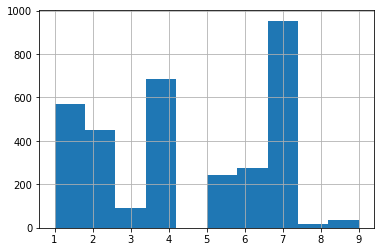

In [103]:
df_train['Class'].hist();

Classes are imbalanced

## Baseline classification

In [131]:
# Helper function

def evaluate_features(X, y, clf=None):
    if clf is None:
        clf = LogisticRegression()
    
    probas = cross_val_predict(clf, X, y, 
                               cv=StratifiedKFold(random_state=42), 
                               method='predict_proba',
                               n_jobs=-1)
    
    pred_indices = np.argmax(probas, axis=1)
    classes = np.unique(y)
    preds = classes[pred_indices]
    print('Log loss: {}'.format(log_loss(y, probas)))
    print('Accuracy: {}'.format(accuracy_score(y, preds)))
    plot_confusion_matrix(y, preds)

In [105]:
# Checking for 'Text' missing-values
df_train[df_train['Text'].isnull()]

,ID,Gene,Variation,Class,Text
1109,1109,FANCA,S1088F,1,NaN
1277,1277,ARID5B,Truncating Mutations,1,NaN
1407,1407,FGFR3,K508M,6,NaN
1639,1639,FLT1,Amplification,6,NaN
2755,2755,BRAF,G596C,7,NaN


In [106]:
# Dropping variants without description 
df_train.dropna(subset=['Text'], inplace=True).reset_index()
df_train[df_train['Text'].isnull()]

,ID,Gene,Variation,Class,Text


In [134]:
# vectorizing free text into features
tv = TfidfVectorizer(
                    tokenizer=nltk.word_tokenize,
                    stop_words='english'
                    )    

In [135]:
# TF-IDF
tfidf = tv.fit_transform(df_train['Text'])

In [136]:
# corpus with 280k words
len(cv.get_feature_names())

280009

In [137]:
svd = TruncatedSVD(n_components=20, n_iter=20, random_state=42)
trunc_tfidf = svd.fit_transform(tfidf)

Log loss: 1.8272300673341655
Accuracy: 0.3615802171290712


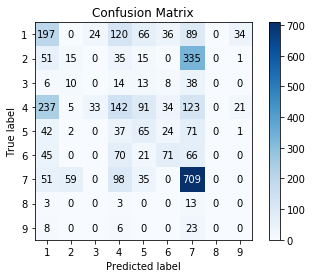

In [140]:
evaluate_features(trunc_tfidf, df_train['Class'].values,
                 SVC(kernel='linear', probability=True))

Results not so promissing.

In [ ]:
# TBD: word2vec